In [2]:
import math
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tqdm import tqdm

# Фильтруем Отзывы

Так как датасет получился достаточно большим, было принято решение отфильтровать его по длинне текста отзыва

In [7]:
text_lengths = []

feedback_pq = pq.ParquetFile('__input__/feedback.parquet')

for batch in tqdm(
    feedback_pq.iter_batches(65536), 
    total=math.ceil(feedback_pq.metadata.num_rows / 65536)
):
    for t in batch['text']:
        text_lengths.append(len(t.as_py()))

feedback_pq.close()

100%|██████████| 2904/2904 [10:03<00:00,  4.81it/s]


In [10]:
max_length = max(text_lengths)

max_length

5000

In [19]:
step = 10
bins = [f'{i} - {i + step}' for i in range(0, max_length, step)]
bins_count = [0 for _ in range(0, max_length, step)]

for l in tqdm(text_lengths):
    bins_count[math.ceil(l / step) - 1] += 1

100%|██████████| 190295785/190295785 [01:23<00:00, 2275169.59it/s]


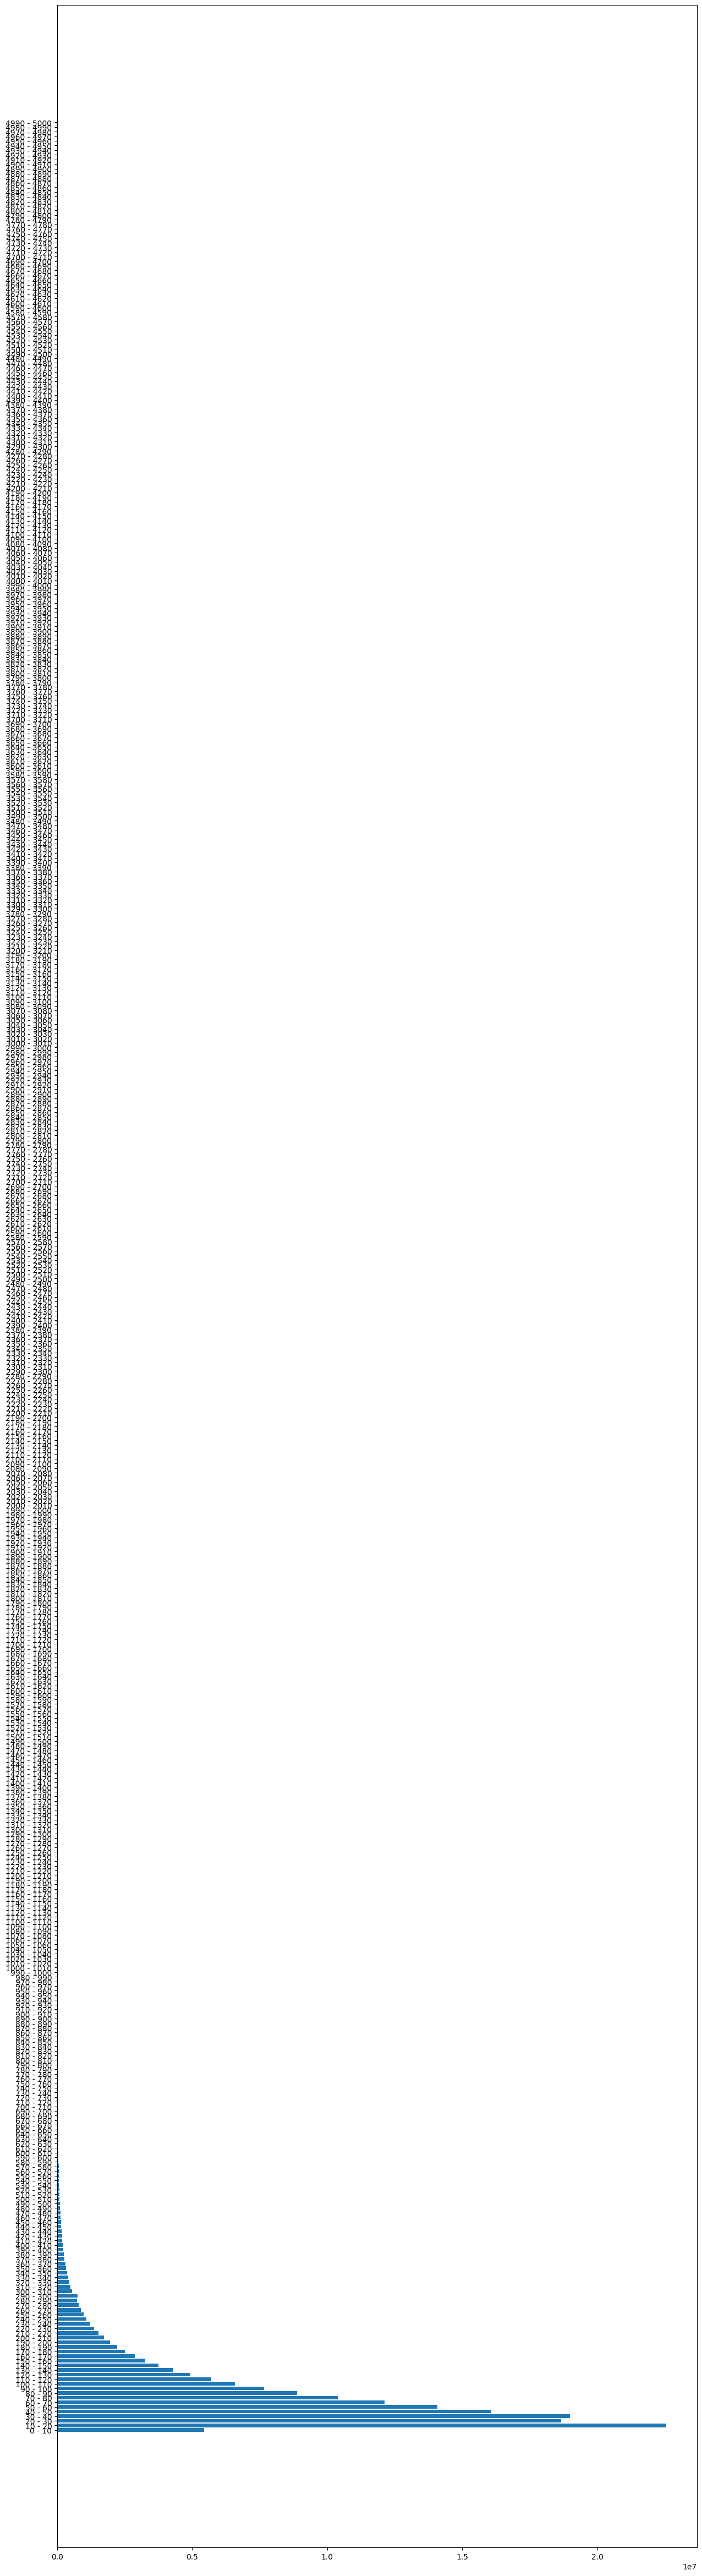

In [23]:
plt.figure(figsize=(15,60))

plt.barh(
    y=bins,
    width=bins_count
)

plt.show()

Мое внимание привлек заметный скачек в районне **300'ого** бина.

Как мне кажется, это может говорить о каких-то координальных различиях между текстами в бинах до и после этого момента, поэтому будет логично взять значения "вокруг" этого бина

Было принято решение взять значения и диапазона - [260; 500]

In [2]:
feedback_pq = pq.ParquetFile('__input__/feedback.parquet')
writer = pq.ParquetWriter(
    '__input__/clean_feedback.parquet',
    pa.schema([
        ('nmId', pa.int64()),
        ('text', pa.string()),
        ('answer', pa.string())
    ])
)

for batch in tqdm(
    feedback_pq.iter_batches(65536), 
    total=math.ceil(feedback_pq.metadata.num_rows / 65536)
):
    df: pd.DataFrame = batch.to_pandas()
    df = df[df['text'].str.len().between(260, 500)].reset_index()
    df = df[[
        'nmId',
        'text',
        'answer'
    ]] # type: ignore
    writer.write_table(pa.Table.from_pandas(df))

feedback_pq.close()
writer.close()

100%|██████████| 2904/2904 [08:52<00:00,  5.45it/s]


Датасет получилось уменьшить до 3.21 GB, тепрь он даже помещается в DataFrame

# Фильтруем Вопросы

Изначальный датасет небольшой, поэтому можно воспользоваться Pandas

In [2]:
questions_df = pd.read_parquet('__input__/questions.parquet')

questions_df

,imtId,nmId,productName,supplierArticle,supplierId,supplierName,brandName,question,answer
0,0,1000211,,T-B-4715-WATCH-BK.MOP,5457,Fashion Web Inc,Bora,часы мужские? или все таки женские?,"Здравствуйте. Мужские. С уважением, Wildberries"
1,0,1001205,,П3065А-17/розовый,16787,Полар Центр ООО,Polar,"Здравствуйте! А вес рюкзака подскажите,пожалуй...",Здравствуйте. Вес рюкзака 1080 гр.
2,0,1001205,,П3065А-17/розовый,16787,Полар Центр ООО,Polar,Подскажи пожалуйста дно мягкое или твердое?,Здравствуйте!Дно уплотненно..
3,0,1001213,,П3821-01/красный,16787,Полар Центр ООО,Polar,Здравствуйте! Какое у него дно? Может ли стоя...,Здравствуйте!Дно рюкзака уплотнено.Вес рюкзака...
4,0,1002463,,3112/черн,18250,Реал Файт ООО,Everlast,добрый день сколько они унций?,Здравствуйте. 12 унций.
...,...,...,...,...,...,...,...,...,...
7410002,999968,1178626,,6612/01/NERO,5130,Грааль ООО,Fly Girl,Здравствуйте! А пуговки не идут в комплекте до...,"Здравствуйте. К сожалению, ответить на Ваш во..."
7410003,999968,1178626,,6612/01/NERO,5130,Грааль ООО,Fly Girl,здравствуйте! ожидается ли поступление товара ...,"Здравствуйте, к сожалению, поступлений данной ..."
7410004,999972,1178631,,6632/01/NERO,5130,Грааль ООО,Fly Girl,"Поясните, на российский 44 р. точно 42 подойде...","Здравствуйте.К сожалению, мы не можем проверит..."
7410005,999980,1178641,,9693/01/VERDE,5130,Грааль ООО,Fly Girl,Здравствуйте. Когда ожидать размер xs?,"Здравствуйте, к сожалению, поступлений данной ..."


In [21]:
step = 10
bins = list(range(0, max(questions_df['question'].str.len()), step))
bins_count = pd.cut(questions_df['question'].str.len(), bins).value_counts().sort_index().to_dict()

bins_labels = [f'{k}' for k in bins_count.keys()]
bins_heights = [v for v in bins_count.values()]

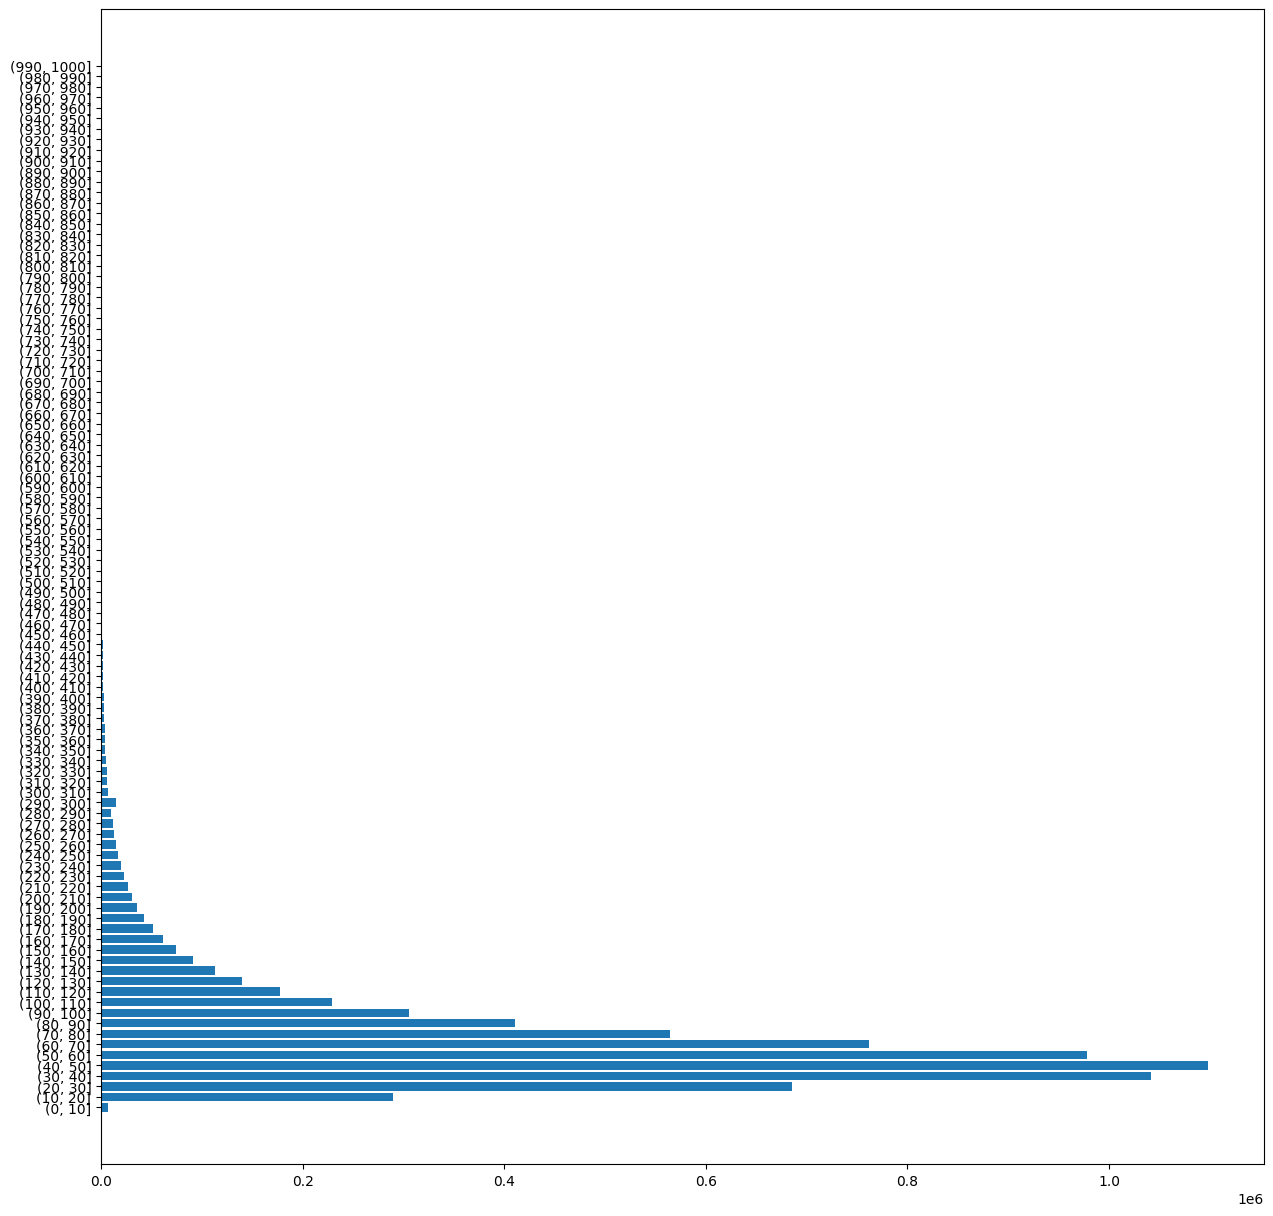

In [22]:
plt.figure(figsize=(15,15))

plt.barh(
    y=bins_labels,
    width=bins_heights
)

plt.show()

Так как датасет сам по себе не слишком большой, ограничился тем, что отбросил тексты меньше 40 символов

In [24]:
questions_df = questions_df[questions_df['question'].str.len() >= 40]

questions_df = questions_df.reset_index()[[
    'nmId',
    'question',
    'answer'
]]

In [23]:
questions_df.to_parquet('./__input__/clean_questions.parquet')

Датасет получилось уменьшить до 775 MB

# Фильтрация Продуктов

Датасет с продуктами мы будем использовать для сбора дополнительной ифнормации по вопросу/отзыву по nmId, так что мы можем отфильтровать все не встречающиеся nmId

In [4]:
nms1 = pd.read_parquet('__input__/clean_feedback.parquet', columns=['nmId'])['nmId']
nms2 = pd.read_parquet('__input__/clean_questions.parquet', columns=['nmId'])['nmId']

nms = pd.concat([nms1, nms2])

del nms1
del nms2

In [5]:
all_nms = set()
for i in nms:
    all_nms.add(i)

In [6]:
products_pq = pq.ParquetFile('__input__/products.parquet')
writer = pq.ParquetWriter('__input__/clean_products.parquet', products_pq.schema_arrow)

for batch in tqdm(
    products_pq.iter_batches(65536), 
    total=math.ceil(products_pq.metadata.num_rows / 65536)
):
    df: pd.DataFrame = batch.to_pandas()
    df = df[df['nm_id'].isin(all_nms)]

    writer.write_table(pa.Table.from_pandas(df, schema=products_pq.schema_arrow))

products_pq.close()
writer.close()

100%|██████████| 2339/2339 [36:58<00:00,  1.05it/s]


Получилось сжать датасет до 2.06 GB